<a href="https://www.kaggle.com/code/dalao1002/cifar-10-object-recognition-in-images?scriptVersionId=156772609" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import platform
import sys

# linear algebra
import numpy as np
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
# plot
import matplotlib
import matplotlib.pyplot as plt
# machine learning
import sklearn
# deep learning
import torch
import torchvision

In [2]:
print("Operating system: ", platform.platform(), platform.version())
print("Python version", sys.version)
print("Pandas version: ", pd.__version__)
print("Sklearn version: ", sklearn.__version__)
print("Pytorch version: ", torch.__version__)

Operating system:  Linux-5.15.133+-x86_64-with-glibc2.31 #1 SMP Tue Dec 19 13:14:11 UTC 2023
Python version 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
Pandas version:  2.0.3
Sklearn version:  1.2.2
Pytorch version:  2.0.0+cpu


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print('Using device:', device)

Using device: cpu


In [4]:
RANDOM_STATE = 0
TRAIN_VS_VALIDATION_SET_PERCENTANGE = 0.8
BATCH_SIZE = 32
TRAIN_FULL_IMAGES_PATH = "/kaggle/temp/train"
TEST_FULL_IMAGES_PATH = "/kaggle/temp/test"
TRAIN_IMAGES_REORGANIZED_PATH = "/kaggle/temp/train_reorganized"
VALID_IMAGES_REORGANIZED_PATH = "/kaggle/temp/valid_reorganized"
TEST_IMAGES_REORGANIZED_PATH = "/kaggle/temp/test_reorganized"
TEST_IMAGES_REORGANIZED_PLACEHOLDER_LABEL_PATH = f"{TEST_IMAGES_REORGANIZED_PATH}/unknown"

In [5]:
# Input data files are available in the read-only "../input/" directory
train_full_labels = pd.read_csv('../input/cifar-10/trainLabels.csv', index_col='id')

In [6]:
from sklearn.model_selection import train_test_split

# Break off validation set from training data
train_labels, valid_labels = train_test_split(
    train_full_labels,
    train_size=TRAIN_VS_VALIDATION_SET_PERCENTANGE,
    # shuffle the dataset to ensure the traning set is representive of the overall distribution of the data,
    # this would be useful e.g. the input is sorted by target label or specific feature.
    shuffle=True,
    random_state=RANDOM_STATE
)

In [7]:
train_labels

,label
id,
20331,cat
17533,horse
45820,dog
34808,horse
31889,airplane
...,...
21244,airplane
45892,dog
42614,dog


In [8]:
!pip install py7zr --quiet

In [9]:
# You can calso write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
!ls "$TRAIN_FULL_IMAGES_PATH" > /dev/null && echo "train set has been already extracted" || python -m py7zr x "../input/cifar-10/train.7z" "/kaggle/temp/"
!ls "$TEST_FULL_IMAGES_PATH" > /dev/null && echo "test set has been already extracted" || python -m py7zr x "../input/cifar-10/test.7z" "/kaggle/temp/"

ls: cannot access '/kaggle/temp/train': No such file or directory
ls: cannot access '/kaggle/temp/test': No such file or directory


In [10]:
# https://d2l.ai/chapter_computer-vision/kaggle-cifar10.html#reading-the-dataset
def reorganize_images(labels, source_path, destination_path):
    for label in train_labels["label"].unique():
        class_path = f"{destination_path}/{label}"
        print(f"creating class path {class_path}")
        os.makedirs(class_path, exist_ok=True)
    for idx, row in labels.iterrows():
        id = row.name
        label = row["label"]
        destination_image_path = f"{destination_path}/{label}/{id}.png"
        if os.path.isfile(destination_image_path):
            os.remove(destination_image_path)
        os.symlink(f"{source_path}/{id}.png", destination_image_path)

reorganize_images(train_labels, TRAIN_FULL_IMAGES_PATH, TRAIN_IMAGES_REORGANIZED_PATH)
reorganize_images(valid_labels, TRAIN_FULL_IMAGES_PATH, VALID_IMAGES_REORGANIZED_PATH)

creating class path /kaggle/temp/train_reorganized/cat
creating class path /kaggle/temp/train_reorganized/horse
creating class path /kaggle/temp/train_reorganized/dog
creating class path /kaggle/temp/train_reorganized/airplane
creating class path /kaggle/temp/train_reorganized/ship
creating class path /kaggle/temp/train_reorganized/truck
creating class path /kaggle/temp/train_reorganized/bird
creating class path /kaggle/temp/train_reorganized/automobile
creating class path /kaggle/temp/train_reorganized/frog
creating class path /kaggle/temp/train_reorganized/deer
creating class path /kaggle/temp/valid_reorganized/cat
creating class path /kaggle/temp/valid_reorganized/horse
creating class path /kaggle/temp/valid_reorganized/dog
creating class path /kaggle/temp/valid_reorganized/airplane
creating class path /kaggle/temp/valid_reorganized/ship
creating class path /kaggle/temp/valid_reorganized/truck
creating class path /kaggle/temp/valid_reorganized/bird
creating class path /kaggle/temp/v

In [11]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#load-and-normalize-cifar10
from torchvision.transforms import Compose, ToTensor, Normalize

mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2023, 0.1994, 0.2010])

# Image data preprocessing pineline
# Composes several transforms together.
transform = Compose([
    # The output of torchvision datasets are PILImage images of range [0, 1]
    # Convert a PIL Image or numpy.ndarray to tensor
    ToTensor(),
    # # We transform them to Tensors of normalized range [-1, 1].
    # Normalize a tensor image with mean and standard deviation
    # input[channel] = (input[channel] - mean[channel]) / std[channel]
    # https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0
    # Standardization improves the numerical stability of your model
    Normalize(mean, std)
])

In [12]:
# 1. Load and normalizing the CIFAR10 training and test datasets using torchvision
from torchvision.datasets import ImageFolder

train_images = ImageFolder(TRAIN_IMAGES_REORGANIZED_PATH, transform=transform)
valid_images = ImageFolder(VALID_IMAGES_REORGANIZED_PATH, transform=transform)

airplane
torch.Size([3, 32, 32])


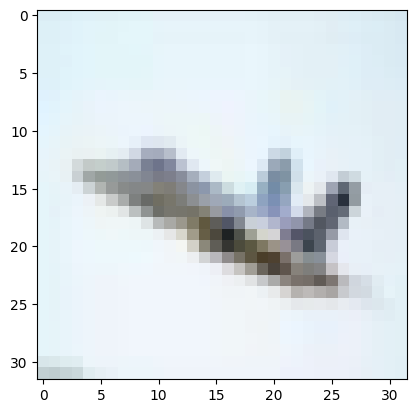

In [13]:
def display_img(img):
    # Permute the dimensions of an array
    # Put the two image axes in the front
    PIL_RGB_image = img.permute(1, 2, 0)
    # unnormalize
    img = PIL_RGB_image * std + mean
    plt.imshow(img.numpy())

sample_image, sample_label_index = train_images[0]
display_img(sample_image)
print(train_images.classes[sample_label_index])
print(sample_image.shape)

In [14]:
# 2. Define a Convolution Neural Network
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [15]:
# 3. Define a Loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

It is an iterative process that gradually try to decrease the loss term. Due to the performance and stability consideration we use small set of samples at one time to update the parameters. We call this batch size, total number of training examples present in a sinple improvement. And we call one epoch when an entire dataset is passed forward and backward through the neural network once. And the number of iteration requiered to pass the whole epoch is calculate as total number of tranning example divided by batch size.

In [16]:
from torch.utils.data import DataLoader

# Create train and validation batch for training
train_loader = DataLoader(dataset=train_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset=valid_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [17]:
# 4. Train the network on the training data
epochs = 2
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        # get the inputs
        sample_images, sample_labels = batch

        # zero the parameter gradients
        # by default PyTorch accumulates the gradients on subsequent backward passes
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_labels = net(sample_images)
        loss = criterion(predicted_labels, sample_labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print every 500 mini-batches
        if batch_index % 500 == 0:
            print(f"epoch {epoch} batch {batch_index} loss {running_loss / 2000}")
        running_loss = 0

    loss = criterion(predicted_labels, sample_labels)
    train_loss = loss.item()

epoch 0 batch 0 loss 0.0011535699367523193
epoch 0 batch 500 loss 0.0011403956413269043
epoch 0 batch 1000 loss 0.0009446997046470642
epoch 1 batch 0 loss 0.0009374363422393799
epoch 1 batch 500 loss 0.000783673882484436
epoch 1 batch 1000 loss 0.000762939989566803


In [18]:
!mkdir -p "$TEST_IMAGES_REORGANIZED_PATH"
!ls "$TEST_IMAGES_REORGANIZED_PLACEHOLDER_LABEL_PATH" > /dev/null && echo "test set has been already linked" || ln -s "$TEST_FULL_IMAGES_PATH" "$TEST_IMAGES_REORGANIZED_PLACEHOLDER_LABEL_PATH"

ls: cannot access '/kaggle/temp/test_reorganized/unknown': No such file or directory


In [19]:
test_images = ImageFolder(TEST_IMAGES_REORGANIZED_PATH, transform=transform)

bird
dog
deer
horse
deer


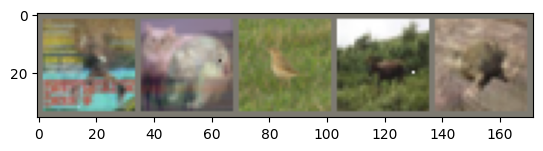

In [20]:
from torch.utils.data import Subset
from torchvision.utils import make_grid

# get some test images
samples_test_images = Subset(test_images, range(5))
sample_images, ignored_labeles_indeces = zip(*samples_test_images)
# show sample test images
display_img(make_grid(list(sample_images)))
# Okay, now let us see what the neural network thinks these examples above are
for sample_image in sample_images:
    pred = net(sample_image)
    print(train_images.classes[pred.argmax()])

In [21]:
test_loader = DataLoader(dataset=test_images, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

preds = []
for X, _ in test_loader:
    y_hat = net(X)
    preds.extend(y_hat.argmax(dim=1))

In [22]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
ids = list(map(lambda image_path: image_path[len(TEST_IMAGES_REORGANIZED_PLACEHOLDER_LABEL_PATH) + 1:-4], map(lambda image_info: image_info[0][0], zip(test_images.imgs))))
df = pd.DataFrame({'id': ids, 'label': map(lambda i: train_images.classes[i], preds)})
df.to_csv('/kaggle/working/submission.csv', index=False)